## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from IPython.display import clear_output

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

# from importlib import reload

In [2]:
import sys
sys.executable

'/usr/bin/python'

### define paths to data

In [3]:
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

'/home/jefan/neurosketch'

In [4]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '2_object_evidence_during_drawing'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import object_evidence_analysis_helpers as utils
reload(utils)
utils.data_dir = data_dir
utils.path_to_recog = os.path.join(data_dir, 'features/recog')
utils.path_to_draw = os.path.join(data_dir, 'features/drawing')
utils.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
utils.roi_list_recog = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
utils.roi_list_recog_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC']) 
roi_list_recog = utils.roi_list_recog

### get file list

In [5]:
## get raw file list for recognition runs
path_to_recog = utils.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [6]:
## get raw file list for drawing runs
path_to_draw = utils.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [7]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#print('Number of subs: {}'.format(len(sub_list)))

In [8]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [9]:
print 'We have data from {} subjects.'.format(len(sub_list))

We have data from 31 subjects.


### PRODUCTION: How well do we do at classifying the target during production runs when we train on initial recognition patterns only?

In [10]:
reload(utils)
version = '4way'
logged = True

really_run = 0
if really_run:

    ALLDM, Acc = utils.make_drawing_predictions(sub_list,roi_list_recog,
                                            version=version,logged=logged)
    ## save out ALLDM & Acc
    Acc = np.array(Acc)
    np.save(os.path.join(results_dir,'object_classifier_accuracy_production.npy'),Acc)
    ALLDM.to_csv(os.path.join(results_dir,'object_classifier_logprobs_production.csv'),index=False)
    
else:
    ## load in existing ALLDM & Acc 
    Acc = np.load(os.path.join(results_dir,'object_classifier_accuracy_production.npy'))
    ALLDM = pd.read_csv(os.path.join(results_dir,'object_classifier_logprobs_production.csv'))
    
print 'Done!'

Done!


#### basic summary plot of classifier accuracy between ROIs

In [11]:
def plot_draw_decoding():

    ## plot test accuracy on drawing runs; trained on recognition runs
    from matplotlib import rc
    hfont = {'fontname':'Helvetica'}    
    Acc = np.load(os.path.join(results_dir,'object_classifier_accuracy_production.npy'))

    Acc = np.array(Acc)
    x = pd.DataFrame(Acc.transpose())
    x.columns = roi_list_recog    
    sns.set_context('talk')
    fig = plt.figure(figsize=(8,8))
    fig = sns.barplot(data=x,palette='husl',ci=95,zorder=1)
    x2 = x
    plt.ylim(0,0.5)

    ## melt into longform dataframe to be able to make stripplot for draw decoding accuracy 
    ## for each subject
    x = x.assign(sub=sub_list)
    xl = pd.melt(x, 
                id_vars=['sub'], 
                var_name='roi',
                value_vars=roi_list_recog, 
                value_name='draw_acc')        
    fig2 = sns.swarmplot(data=xl,x="roi", 
                         y="draw_acc", 
                         #color=(0.25,0.25,0.25),
                         palette='husl',
                         dodge=True,
    #                      jitter=0.12,
                         alpha=0.6,    
                         size=6,
                         edgecolor=(0.1,0.1,0.1),
                         linewidth=1,
                         zorder=2)    

    fig3 = sns.barplot(data=x2,palette='husl',ci=95,alpha=0.1,zorder=3)
    plt.xlabel('')

    chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
    plt.axhline(chance_dict[version],linestyle=':',color='k')
    plt.ylabel('object decoding accuracy',fontsize=20, **hfont)
    plt.title('drawing', **hfont)
    fig.set_xticklabels(utils.roi_list_recog_formatted,fontsize=16, **hfont)
    out_path = os.path.join(proj_dir,'plots/{}/draw_decoding_accuracy.pdf'.format(nb_name))
    plt.savefig(out_path,format='pdf')        
        

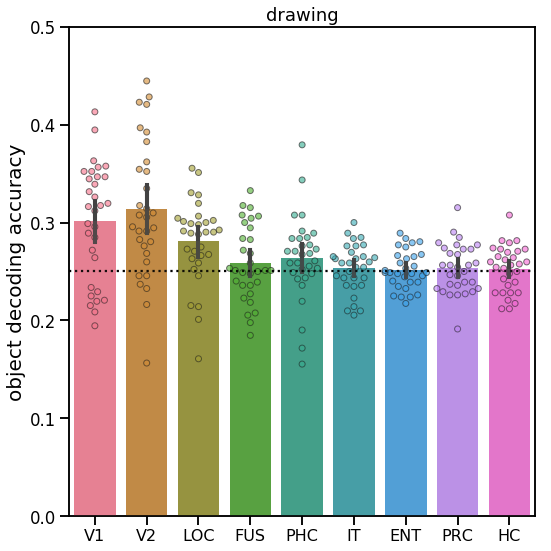

In [12]:
plot_draw_decoding()

### make summary timecourse plots

In [13]:
reload(utils)
# versions = ['2way','3way','4way', '4wayIndependent']
versions = ['4way']
tags = ['logged']
# tags = ['logged', 'raw']
iv_list = ['time_point','trial_num','run_num']

reallyRun = 1
if reallyRun:
    for version in versions:
        for tag in tags:
            ALLDM = pd.read_csv(os.path.join(results_dir, 'object_classifier_logprobs_production.csv'))
            try:
                utils.plot_summary_timecourse(ALLDM,
                                        this_iv='trial_num',
                                        roi_list=roi_list_recog,
                                        render_cond=1,
                                        version = version,
                                        proj_dir=proj_dir)
            except KeyError:
                pass

Now plotting results for V1 ...
Now plotting results for V2 ...
Now plotting results for LOC ...
Now plotting results for IT ...
Now plotting results for fusiform ...
Now plotting results for parahippo ...
Now plotting results for PRC ...
Now plotting results for ento ...
Now plotting results for hipp ...


#### get subject-level index of contrast between objects during drawing


In [14]:
reload(utils)
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version = '4way'
tag = 'logged'
this_iv = 'time_point' ## other options 'run_num','trial_num','time_point'

ALLDM = pd.read_csv(os.path.join(results_dir,'object_classifier_logprobs_production.csv'))
d = utils.get_log_odds(ALLDM,
               this_iv = this_iv,
               roi_list = roi_list_recog,
               phase = 'production',
               version=version,
               logged=True,
               proj_dir=proj_dir)


roi
IT           1.006932
LOC          1.437331
PRC          0.999914
V1           2.533212
V2           3.097409
ento         1.020229
fusiform     1.198618
hipp         1.026324
parahippo    0.986917
Name: target-foil, dtype: float64


In [15]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print('------- condition: {} -------'.format(condition))
    for this_roi in roi_list_recog:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p1,p2 = utils.bootstrapCI(data,3000)
        print('ROI = {} | mean = {}  95% CI: [{} {}] p(x<0)={} p(x>0)={}'.format(
            this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p1,5),np.round(p2,5)))

------- condition: target-foil -------
ROI = V1 | mean = 0.69537  95% CI: [0.472 0.92675] p(x<0)=0.0 p(x>0)=2.0
ROI = V2 | mean = 0.79072  95% CI: [0.544 1.05588] p(x<0)=0.0 p(x>0)=2.0
ROI = LOC | mean = 0.32103  95% CI: [0.227 0.42033] p(x<0)=0.0 p(x>0)=2.0
ROI = IT | mean = -0.01536  95% CI: [-0.088 0.05629] p(x<0)=1.31 p(x>0)=0.69
ROI = fusiform | mean = 0.15829  95% CI: [0.081 0.23466] p(x<0)=0.0 p(x>0)=2.0
ROI = parahippo | mean = -0.02608  95% CI: [-0.081 0.0295] p(x<0)=1.63267 p(x>0)=0.36733
ROI = PRC | mean = -0.01341  95% CI: [-0.07 0.04382] p(x<0)=1.37467 p(x>0)=0.62533
ROI = ento | mean = 0.00705  95% CI: [-0.052 0.06451] p(x<0)=0.80867 p(x>0)=1.19133
ROI = hipp | mean = 0.01326  95% CI: [-0.042 0.07028] p(x<0)=0.64067 p(x>0)=1.35933
------- condition: target-control -------
ROI = V1 | mean = 0.247  95% CI: [0.112 0.38658] p(x<0)=0.0 p(x>0)=2.0
ROI = V2 | mean = 0.29115  95% CI: [0.148 0.43985] p(x<0)=0.0 p(x>0)=2.0
ROI = LOC | mean = 0.15865  95% CI: [0.066 0.26208] p(x<0)=